In [176]:
%pip install jax numpy matplotlib moviepy proglog flax optax ipykernel

Note: you may need to restart the kernel to use updated packages.


In [177]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import jax.random as random
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

#version更新によって削除されている
#from jax.experimental import stax
from flax import linen as nn
#from jax.experimental import optimizers
import optax

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

In [178]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2

  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

In [179]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [180]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

In [181]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

#時間発展における1ステップ先の状態を返す
def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [182]:
#choose an initial state
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.linspace(0, 40, num = 401, dtype=np.float32)

In [183]:
# compute dynamics analytically
%time x_analytical = jax.device_get(solve_analytical(x0, t))
noise_coeff_1, noise_coeff_2 = 1e-10, 1e-11
x_perturbed_1 = jax.device_get(solve_analytical(x0 + noise_coeff_1 * noise, t))
x_perturbed_2 = jax.device_get(solve_analytical(x0 + noise_coeff_2 * noise, t))

CPU times: total: 203 ms
Wall time: 172 ms


In [184]:
# compute dynamics via autograd / the rewritten E-L equation
%time x_autograd = jax.device_get(solve_autograd(x0, t))

CPU times: total: 1.19 s
Wall time: 750 ms


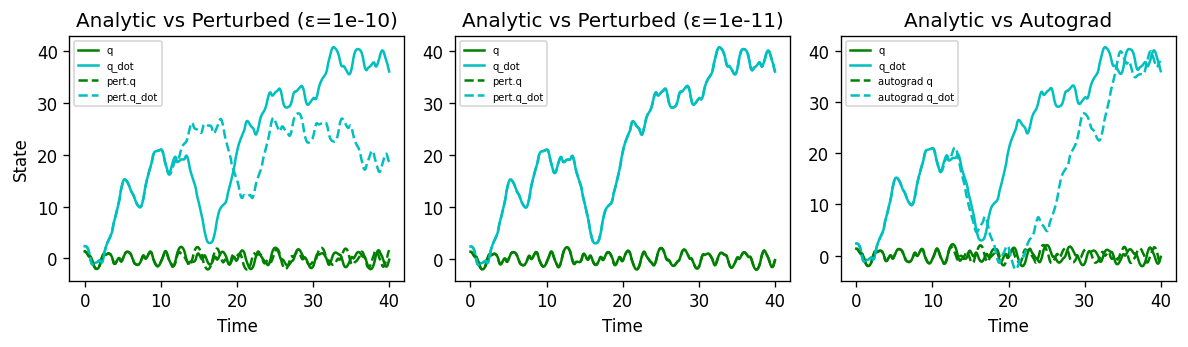

In [185]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=120)
(ax1, ax2, ax3) = axes

# === 1 ===
ax1.set_title("Analytic vs Perturbed (ε=1e-10)")
ax1.plot(t, x_analytical[:, 0], 'g-', label='q')
ax1.plot(t, x_analytical[:, 1], 'c-', label='q_dot')
ax1.plot(t, x_perturbed_1[:, 0], 'g--', label='pert.q')
ax1.plot(t, x_perturbed_1[:, 1], 'c--', label='pert.q_dot')
ax1.set_xlabel("Time")
ax1.set_ylabel("State")
ax1.legend(fontsize=6)

# === 2 ===
ax2.set_title("Analytic vs Perturbed (ε=1e-11)")
ax2.plot(t, x_analytical[:, 0], 'g-', label='q')
ax2.plot(t, x_analytical[:, 1], 'c-', label='q_dot')
ax2.plot(t, x_perturbed_2[:, 0], 'g--', label='pert.q')
ax2.plot(t, x_perturbed_2[:, 1], 'c--', label='pert.q_dot')
ax2.set_xlabel("Time")
ax2.legend(fontsize=6)

# === 3 ===
ax3.set_title("Analytic vs Autograd")
ax3.plot(t, x_analytical[:, 0], 'g-', label='q')
ax3.plot(t, x_analytical[:, 1], 'c-', label='q_dot')
ax3.plot(t, x_autograd[:, 0], 'g--', label='autograd q')
ax3.plot(t, x_autograd[:, 1], 'c--', label='autograd q_dot')
ax3.set_xlabel("Time")
ax3.legend(fontsize=6)

plt.tight_layout()
plt.show()
#はじめの方で予測できていればそれで良い(なぜなら摂動によるゆらぎがものすごいから)
#摂動による外部的なゆらぎと、autogradのズレという内部的な要因が同じ不安定性に基づいていることを示している

In [186]:
time_step = 0.01
N = 1500
#x以外を固定する。また解析解は時間に依存していない(状態を時間発展)、またvmapにより各状態xから次の状態yを並列計算するための関数
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.arange(N, dtype=np.float32) # time steps 0 to N

%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps, 時間発展の微分方程式を解くことで、各時刻の状態ベクトルを格納
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state, state(x)の時間微分を計算している
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step, ある状態から次の位置をRK4法を用いて並列計算で求める

noise = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
%time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
%time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
%time y_test = jax.device_get(analytical_step(x_test)) # analytical next step


CPU times: total: 2.66 s
Wall time: 2.64 s
CPU times: total: 0 ns
Wall time: 7.61 ms
CPU times: total: 172 ms
Wall time: 95.6 ms
CPU times: total: 2.53 s
Wall time: 2.55 s
CPU times: total: 0 ns
Wall time: 7.03 ms
CPU times: total: 15.6 ms
Wall time: 656 μs


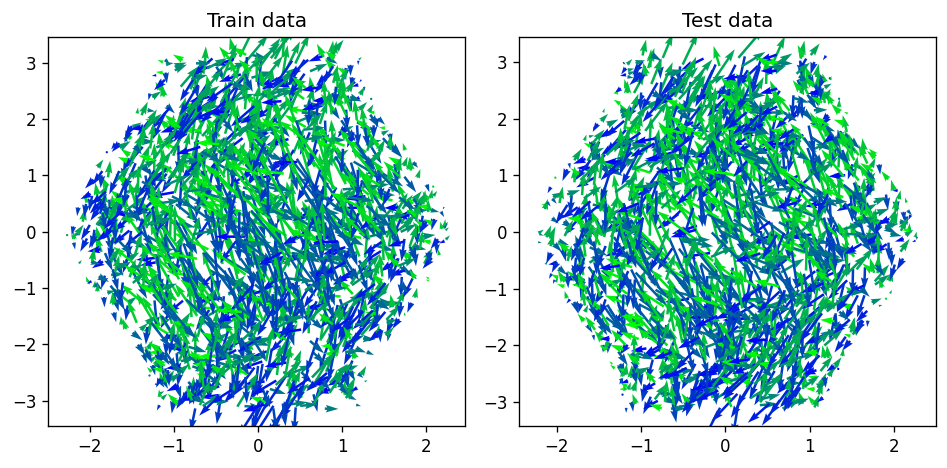

In [187]:
# preprocess, 状態を正規化している。特にθについて
train_vis = jax.vmap(normalize_dp)(x_train)
test_vis = jax.vmap(normalize_dp)(x_test)

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2 #方向ベクトルの角度を[0, 1]に変換している
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T #RGB, R=0, [3, N]→[N, 3]に転置している
train_colors = vel_color(vel_angle(train_vis)) #vel_angleという無名関数にtrain_visを渡して規格化した角度を渡す→それをもとに色に変換
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Train data") ; plt.xlabel(r'') ; plt.ylabel(r'')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'') ; plt.ylabel(r'')
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()

In [188]:
#LNNモデルと損失関数を構築
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

#ここから下が独自の設定

class LNNModel(nn.Module):
    hidden_dim: int = 128
    @nn.compact #__call__の中でレイヤーを定義するため
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim)(x) #全結合層
        x = nn.softplus(x) #活性化関数
        x = nn.Dense(self.hidden_dim)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        return x

# モデル構築
model = LNNModel(hidden_dim=128)
params = model.init(random.PRNGKey(0), jnp.ones((1, 4)))
# 使い方（staxと同様に）
nn_forward_fn = lambda params, x: model.apply(params, x)

In [189]:
# step用更新関数
def update_timestep(params, opt_state, batch, time_step, optimizer):
    grads = jax.grad(loss)(params, batch, time_step)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state#パラメータの更新

def update_derivative(params, opt_state, batch, optimizer):
    grads = jax.grad(loss)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state#パラメータの更新

# データをGPU/TPUに転送して正規化
x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

In [207]:
# バッチ設定
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# 学習率スケジュール (元の jnp.select の代替)
boundaries = [batch_size * (num_batches // 3), batch_size * (2 * num_batches // 3)]
values = [1e-4, 3e-5, 1e-5]
schedule = optax.piecewise_constant_schedule(init_value=1e-4, boundaries_and_scales={
    boundaries[0]: values[1]/values[0],
    boundaries[1]: values[2]/values[1]
})

# オプティマイザ定義
optimizer = optax.chain(
    # 上限値を1.0に設定 (この値は調整可能)
    optax.clip(1.0),
    optax.adam(schedule)
)
#optimizer = optax.adam(schedule)

opt_state = optimizer.init(params)  # paramsは初期パラメータ
key = random.PRNGKey(0)
_update_derivative = partial(update_derivative, optimizer=optimizer)
_update_derivative = jax.jit(_update_derivative)

# トレーニングループ
for iteration in range(batch_size * num_batches + 1):
    key, subkey = random.split(key)
    ix = random.randint(subkey, (batch_size,), 0, len(x_train))
    batch = (x_train[ix, :], xt_train[ix, :])

    if iteration % batch_size == 0:
        train_loss = loss(params, (x_train, xt_train))
        test_loss = loss(params, (x_test, xt_test))
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if iteration % (batch_size * test_every) == 0:
            print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
    params, opt_state = _update_derivative(params, opt_state, batch)


iteration=0, train_loss=396.210419, test_loss=394.160370
iteration=1000, train_loss=221.101120, test_loss=796.396484
iteration=2000, train_loss=1769.828125, test_loss=1832.595459
iteration=3000, train_loss=215.860703, test_loss=196.480331
iteration=4000, train_loss=168.743210, test_loss=175.870117
iteration=5000, train_loss=164.244629, test_loss=254.994247
iteration=6000, train_loss=168.587616, test_loss=222.999969
iteration=7000, train_loss=166.469284, test_loss=258.244202
iteration=8000, train_loss=171.359726, test_loss=395.122131
iteration=9000, train_loss=380.436249, test_loss=1597.582275
iteration=10000, train_loss=769.907349, test_loss=173.057648


KeyboardInterrupt: 

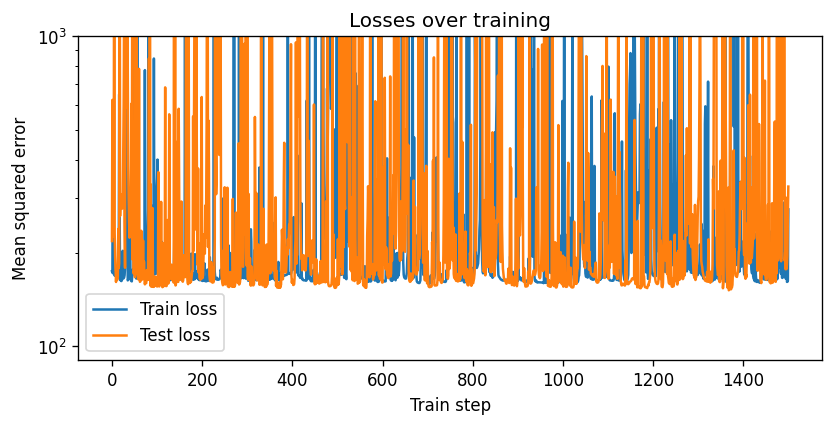

In [205]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.yscale('log')
plt.ylim(None, 1000)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()